# Model Arima for Time Series Forecasting temperature

## LLibreries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [131]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(os.getcwd(), carpeta_dades, fitxer_dades)


    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head(10)


,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
5,1998-01-01 05:00:00+00:00,-6.00
6,1998-01-01 06:00:00+00:00,-6.00
7,1998-01-01 07:00:00+00:00,-6.00
8,1998-01-01 08:00:00+00:00,-5.60
9,1998-01-01 09:00:00+00:00,-4.60


In [132]:
# Intentem unificar les dades en promig de cada 6 hores.
# Es a dir, fem un dataframe on les dades que afegirem sera el promig del valor cada 6 hores. Per tant serà una entrada a les 6h, 12h, 18h i 24h.
# Respectant els horaris de les dades originals seria, per cada dia, interval de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59.

# Convertim la columna 'data' a datetime si no ho està
df['data'] = pd.to_datetime(df['data'])

# Assignem cada registre al seu interval corresponent de 6 hores
# Els intervals seran: 00:00-05:59, 06:00-11:59, 12:00-17:59 i 18:00-23:59
df['interval_6h'] = df['data'].dt.floor('6H')

# Creem un nou dataframe agrupant les dades per intervals de 6 hores i calculant el promig
df_agrupades = df.groupby('interval_6h', as_index=False)['valor'].mean()

# Canviem el nom de la columna de data per mantenir la coherència
df_agrupades.rename(columns={'interval_6h': 'data'}, inplace=True)

# Ordenem el dataframe per data
df_agrupades = df_agrupades.sort_values(by='data').reset_index(drop=True)

# Mostrem les primeres files per verificar el resultat
df_agrupades.head(10)

/tmp/ipykernel_9044/2519749339.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['interval_6h'] = df['data'].dt.floor('6H')


,data,valor
0,1998-01-01 00:00:00+00:00,-5.38
1,1998-01-01 06:00:00+00:00,-4.73
2,1998-01-01 12:00:00+00:00,-1.98
3,1998-01-01 18:00:00+00:00,-1.80
4,1998-01-02 00:00:00+00:00,-2.07
5,1998-01-02 06:00:00+00:00,1.02
6,1998-01-02 12:00:00+00:00,-1.62
7,1998-01-02 18:00:00+00:00,-3.53
8,1998-01-03 00:00:00+00:00,-2.18
9,1998-01-03 06:00:00+00:00,2.15


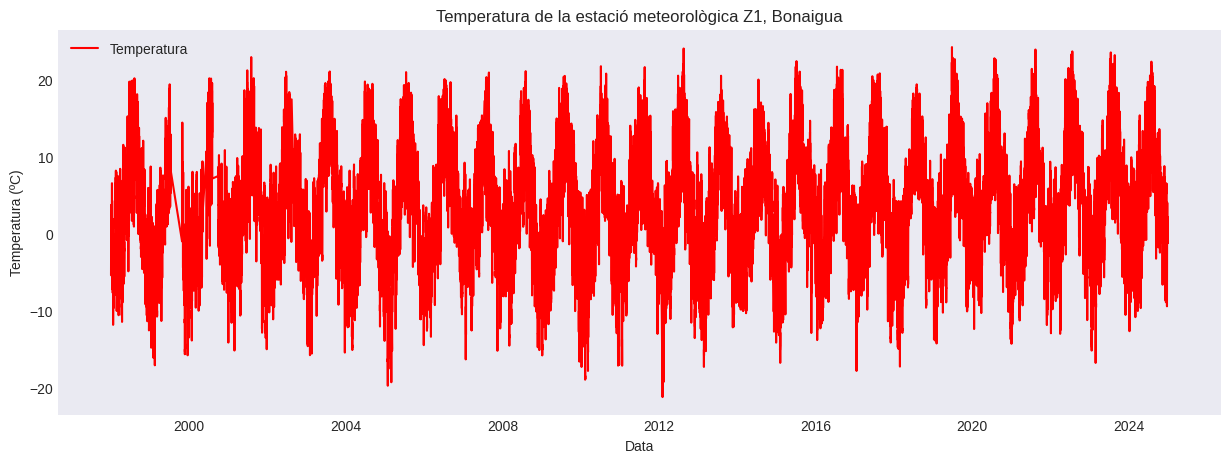

In [133]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df_agrupades['data'], df_agrupades['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Construcció model ARIMA

In [134]:
data = df_agrupades.copy()
data.set_index('data', inplace=True)
data.head(10)

,valor
data,
1998-01-01 00:00:00+00:00,-5.38
1998-01-01 06:00:00+00:00,-4.73
1998-01-01 12:00:00+00:00,-1.98
1998-01-01 18:00:00+00:00,-1.80
1998-01-02 00:00:00+00:00,-2.07
1998-01-02 06:00:00+00:00,1.02
1998-01-02 12:00:00+00:00,-1.62
1998-01-02 18:00:00+00:00,-3.53
1998-01-03 00:00:00+00:00,-2.18


In [136]:
# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA


# Definim els paràmetres p, d i q
p = 5*4  # Ordre de l'auto-regressió
d = 1  # Ordre de la diferenciació
q = 5  # Ordre de la mitjana mòbil

# Creem el model ARIMA
model = ARIMA(data['valor'], order=(p, d, q))

# Ajustem el model
model = model.fit()

# Mostrem el resum del model ajustat
print(model.summary())


/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/prp/Escriptori/TFM_SCM_Temperature_Forecasting_ML/.venv/lib/python3.12/site-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                38373
Model:                ARIMA(20, 1, 5)   Log Likelihood              -72270.551
Date:                Fri, 04 Apr 2025   AIC                         144593.101
Time:                        13:55:00   BIC                         144815.533
Sample:                             0   HQIC                        144663.645
                              - 38373                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0425      0.207      0.205      0.838      -0.364       0.449
ar.L2         -0.1036      0.047     -2.218      0.027      -0.195      -0.012
ar.L3          0.0070      0.031      0.230      0.8

In [138]:
# Predicció de tota la serie temporal

# Realitzem la predicció 
# Funcio get_prediction() retorna un objecte PredictionResults on tambe s'inclouen els intervals de confiança i altres estadístiques
# Si nomes volguessim la predicció, podríem utilitzar la funció predict() que retorna un array amb les prediccions
predictions = model.get_prediction(start=data.index[0], end=data.index[-1], dynamic=False)

# Obtenim les prediccions i els intervals de confiança a partir de l'objecte PredictionResults
predicted_value = predictions.predicted_mean # Predicció 
conf_int = predictions.conf_int() # Interval de confiança

# Afegir les prediccions al dataframe original en una columna nova
data['predicted_values'] = predicted_value
data['predicted_lower'] = conf_int['lower valor']
data['predicted_upper'] = conf_int['upper valor']

# afegim columna de error
data['error'] = data['valor'] - data['predicted_values']
# afegim columna de error quadrat
data['error_squared'] = data['error'] ** 2
# afegim columna de error absolut
data['error_absolute'] = data['error'].abs()
# afegim columna de error absolut quadrat
data['error_absolute_squared'] = data['error_absolute'] ** 2


# Mostrem les primeres files del dataframe amb les prediccions
data.head(10)


,valor,predicted_values,predicted_lower,predicted_upper,error,error_squared,error_absolute,error_absolute_squared
data,,,,,,,,
1998-01-01 00:00:00+00:00,-5.38,0.00,-1959.97,1959.97,-5.38,28.98,5.38,28.98
1998-01-01 06:00:00+00:00,-4.73,-5.38,-9.23,-1.53,0.65,0.42,0.65,0.42
1998-01-01 12:00:00+00:00,-1.98,-4.66,-8.49,-0.83,2.68,7.18,2.68,7.18
1998-01-01 18:00:00+00:00,-1.80,-1.80,-5.42,1.82,-0.00,0.00,0.00,0.00
1998-01-02 00:00:00+00:00,-2.07,-2.65,-6.26,0.97,0.58,0.34,0.58,0.34
1998-01-02 06:00:00+00:00,1.02,-1.91,-5.39,1.57,2.93,8.56,2.93,8.56
1998-01-02 12:00:00+00:00,-1.62,2.39,-1.00,5.79,-4.01,16.06,4.01,16.06
1998-01-02 18:00:00+00:00,-3.53,-3.19,-6.52,0.15,-0.35,0.12,0.35,0.12
1998-01-03 00:00:00+00:00,-2.18,-3.99,-7.32,-0.66,1.81,3.27,1.81,3.27


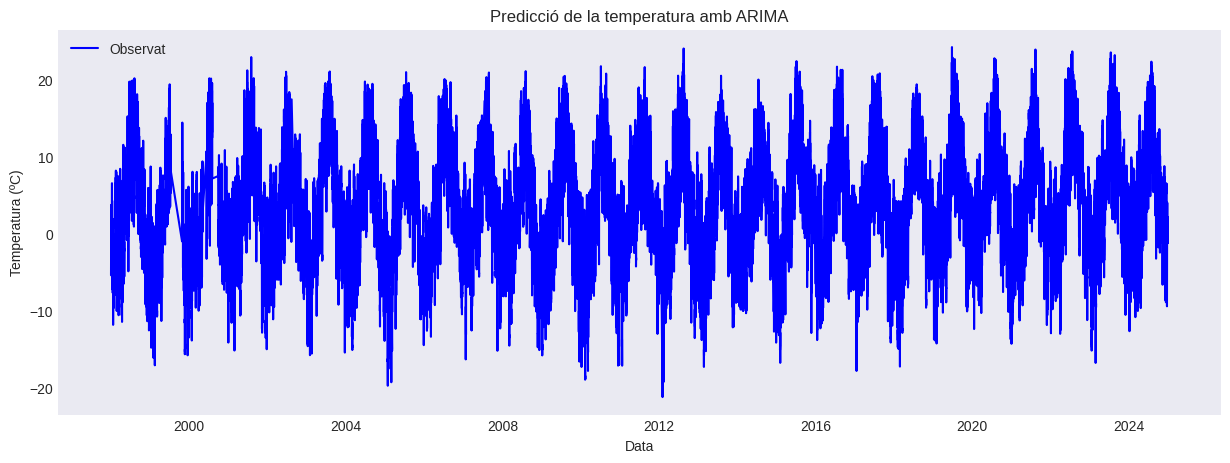

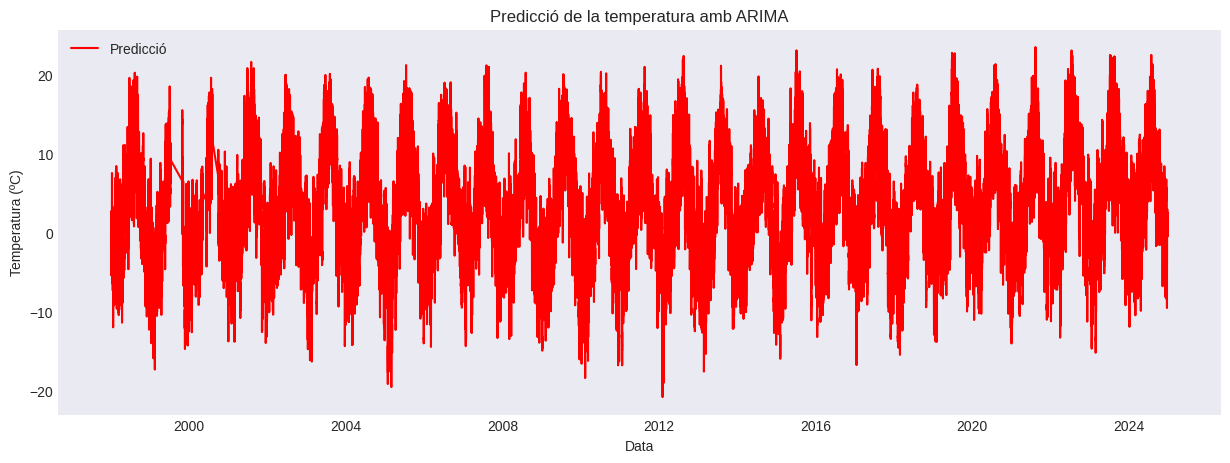

In [139]:

# Plotem els resultats
plt.figure(figsize=(15, 5))
plt.plot(data['valor'], label='Observat', color='blue')
# plt.plot(predicted_mean, label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


# Plot predicció

plt.figure(figsize=(15, 5))
plt.plot(predicted_value, label='Predicció', color='red')
plt.title('Predicció de la temperatura amb ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


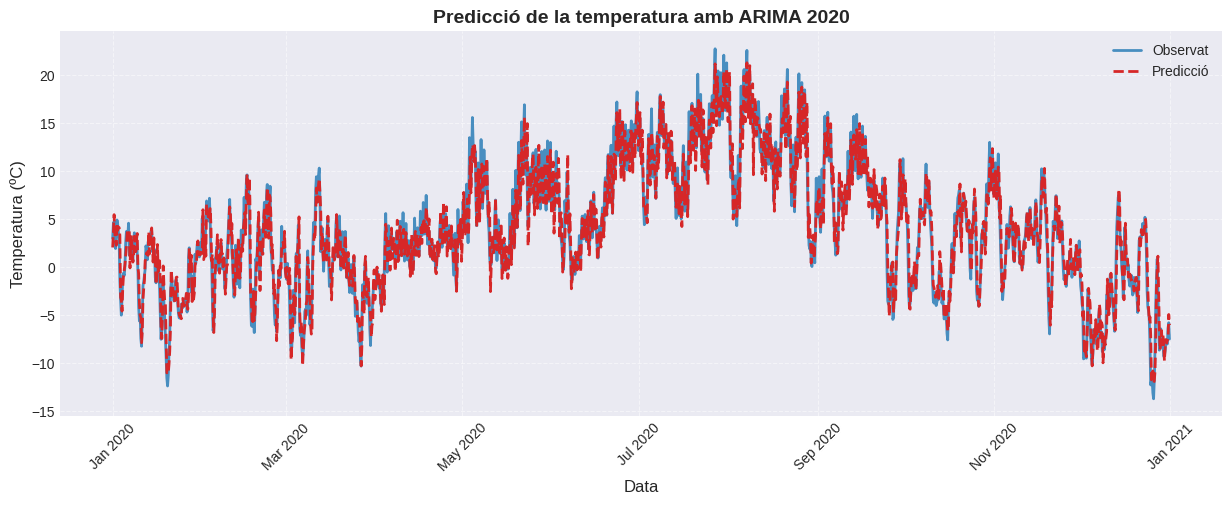

In [140]:
# Mateix plot pero ens fixem nomes en 2015

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

any = '2020'

plt.style.use("seaborn-v0_8-darkgrid")  # Millora l'estil del gràfic

fig, ax = plt.subplots(figsize=(15, 5))

# Gràfica de dades observades
ax.plot(data['valor'][any], label='Observat', color='#1f77b4', linewidth=2, alpha=0.8)

# Gràfica de la predicció
ax.plot(predicted_value[any], label='Predicció', color='#d62728', linestyle='dashed', linewidth=2)

# Gràfica de l'interval de confiança
# ax.fill_between(data.index[any], data['predicted_lower'][any],data['predicted_upper'][any], color='gray', alpha=0.2, label='Interval de confiança')


# Format de la graella i de les dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format curt de mes i any
plt.xticks(rotation=45)

# Etiquetes i títol
plt.title(f'Predicció de la temperatura amb ARIMA {any}', fontsize=14, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Temperatura (ºC)', fontsize=12)

# Llegenda i grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


In [141]:
# Valorem el RMSE i MAE
# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(data['valor'], predicted_value))
print('RMSE:', rmse)

# Calcula el MAE
mae = mean_absolute_error(data['valor'], predicted_value)
print('MAE:', mae)

# Calcula el MSE
mse = mean_squared_error(data['valor'], predicted_value)
print('MSE:', mse)


RMSE: 1.591360667715052
MAE: 1.2195525765744348
MSE: 2.532428774750496


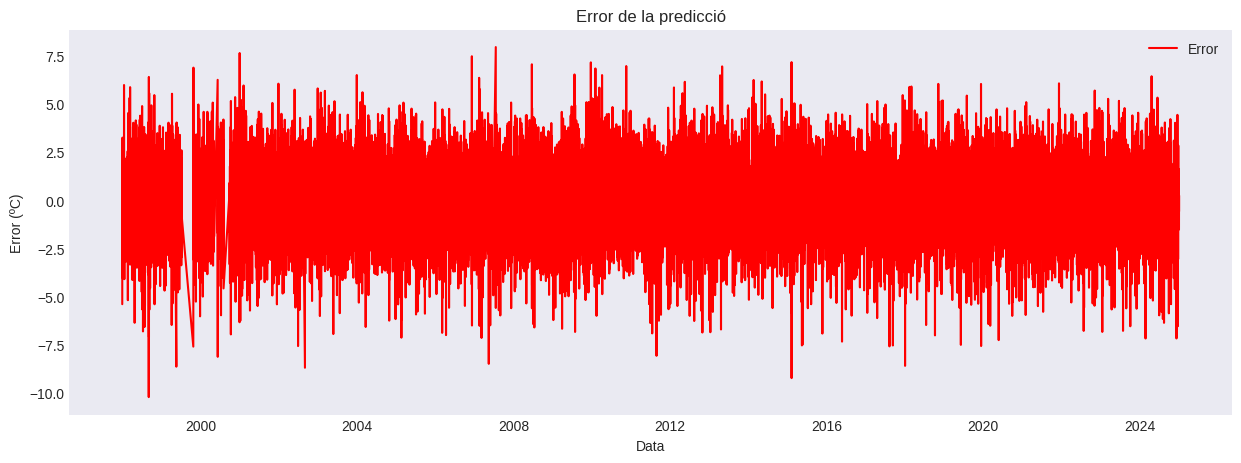

In [142]:
# Plot dels errors
plt.figure(figsize=(15, 5))
plt.plot(data['error'], label='Error', color='red')
plt.title('Error de la predicció')
plt.xlabel('Data')
plt.ylabel('Error (ºC)')
# plt.xlim('Jan 01 2022', 'Dec 31 2022')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# Predir del 2025 fins al març del 2026
# Definim el rang de dates per a la predicció amb el mateix format que el dataframe original
start_date = '2025-01-01'
end_date = '2026-03-31'

# Convertim les dates a datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Realitzem la predicció
predictions_future = model.get_prediction(start=start_date, end=end_date, dynamic=False)



KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'